# HEATMAP VISUALIZATION

In this section, we use the data in csv files to create heatmaps of test statistics (z-scores, Poisson statistics, and frequencies).
The two files that we use are in the data folder:

* RO_RE.csv contains the number of motifs using simple definitions of observation and experience for each network (one empirical network and 1,000 randomized networks).
* SO_SE.csv contains the number of motifs using strict definitions of observation and experience for each network.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import matplotlib
from matplotlib.colors import DivergingNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors
import scipy.stats
from scipy.stats import norm
import sys
import pprint

In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'PiYG',
    'axes.linewidth': 0.25,
    'axes.grid': False,
    'savefig.dpi': 400,
    'axes.labelsize': 7,
    'axes.titlesize': 9,
    'axes.facecolor': 'white',
    'xtick.major.size': 2,
    'ytick.major.width': 0.25,
    'ytick.major.size': 2,
    'xtick.major.width': 0.25,
    'xtick.major.pad': '4',
    'ytick.major.pad': '4',
    'xtick.minor.size': 2,
    'ytick.minor.width': 0.25,
    'ytick.minor.size': 2,
    'xtick.minor.width': 0.25,
    'font.size': 7, 
    'legend.fontsize': 7,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'lines.linewidth': 0.25,
    'patch.linewidth': 0.25,
    'figure.figsize': [7, 7],
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial'
}
matplotlib.rcParams.update(params)


def colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar


def plot_heatmap(ax, piv, xticks, yticks, title, cbar=False):
    colnorm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)
    img1 = ax.imshow(piv, alpha=0.8, norm=colnorm)
    ax.set_xticks(np.arange(piv.shape[1]))
    ax.set_xticklabels(xticks)
    ax.set_yticks(np.arange(piv.shape[0]))
    ax.set_yticklabels(yticks)
    ax.title.set_text(title)
    ax.set_xlabel(r'Observation of $n_o$ cheaters')
    ax.set_ylabel(r'Victimization by $n_v$ cheaters')

    textcolors = ["k", "w"]
    for x in range(piv.shape[1]):
        for y in range(piv.shape[0]):
            if np.isnan(piv.iloc[y, x]) == False:
                p = piv.iloc[y, x]
                # Put the proportion and its standard error for each cell.
                text = ax.text(x, y, ('%.3f\n(%.3f)' % (piv.iloc[y, x], (p*(1-p) / 1000)**0.5)).replace('0.', '.'), 
                               ha="center", va="center", fontsize=6,
                               color=textcolors[1 if piv.iloc[y, x] <= 0.01 or piv.iloc[y, x] >= 0.85 else 0])
    if cbar:
        cbar = colorbar(img1)
        cbar.solids.set_edgecolor("face")
    return img1

## 1 DETAIL HEATMAP OF CUMULATIVE PROBABILITY

In [4]:
def get_motif_stats(fname, max_obs, max_exp, stat):
    df = pd.read_csv(fname)
    df = df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

    col_list = list(df.columns[2:])
    res = df.groupby([df.total_exp, pd.cut(df.total_obs, 
                                           [-np.inf] + list(range(max_obs)) + [np.inf], 
                                           labels = list(range(max_obs+1)))])[col_list].sum().reset_index()

    df = res.groupby([res.total_obs, pd.cut(res.total_exp,[-np.inf] + list(range(max_exp)) + [np.inf], 
                                                  labels = list(range(max_exp+1)))])[col_list].sum().reset_index()
    if stat == 'poisson p':
        df['rand_mean'] = df.iloc[:, 3:].mean(axis=1)
        df['cdf'] = scipy.stats.poisson.cdf(df['E'], df['rand_mean'])
        df['pmf'] = scipy.stats.poisson.pmf(df['E'], df['rand_mean'])
        df['p'] = 1 - df['cdf'] + df['pmf']
    elif stat == 'cum prop':
        x = df.iloc[:, 3:].ge(df.iloc[:, 2], axis=0).sum(axis=1)
        df['p'] = x / 1000 # number of randomizations

    piv = pd.pivot_table(df, values="p", index=["total_exp"], columns=["total_obs"])
    return piv

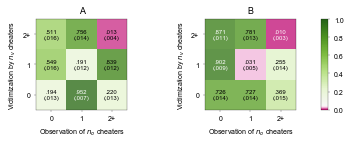

In [5]:
xticks = [0, 1, '2+']
yticks = [0, 1, '2+']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 1.9))
piv1 = get_motif_stats('data/RO_RE.csv', max_obs=2, max_exp=2, stat='cum prop') 
img1 = plot_heatmap(ax1, piv1, xticks, yticks, 'A', cbar=False)

piv2 = get_motif_stats('data/SO_SE.csv', max_obs=2, max_exp=2, stat='cum prop')
img2 = plot_heatmap(ax2, piv2, xticks, yticks, 'B', cbar=False)

plt.subplots_adjust(left=0.04, bottom=0.22, top=0.88, wspace=0.2)
cax = plt.axes([0.9, 0.22, 0.02, 0.66])
cbar = fig.colorbar(img1, cax=cax)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/paper/fig_4.pdf', format='pdf')

## 2 HEATMAP FOR BASIC (1, 0), (0, 1), AND (1, 1) MOTIFS

In [6]:
def calc_basic_motifs(fname, motif):
    df = pd.read_csv(fname)

    # Drop the rows with zero experience or zero observation.
    df = df.drop(df[(df.total_obs == 0) & (df.total_exp == 0)].index)
    df = df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
    
    if motif == (0, 1):
        df = df[df.total_exp == 0]
        temp_dat = df.loc[:,'E':].multiply(df['total_obs'], axis="index")
    elif motif == (1, 0):
        df = df[df.total_obs == 0]
        temp_dat = df.loc[:,'E':].multiply(df['total_exp'], axis="index")
    elif motif == (1, 1):
        df['num_pairs'] = np.where(df['total_obs'] <= df['total_exp'], 
                                 df['total_obs'], df['total_exp'])
        temp_dat = df.loc[:,'E':'R1000'].multiply(df['num_pairs'], axis="index")
    
    # Calculate the total number of the motif for each network
    temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
    cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
    cum_prop = cnt / 1000

    # Calculate p-values
    rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
    rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
    z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0], loc=rand_mean, scale=rand_std))
    z_pval = 1 - norm.cdf(z_score)
    poiss_cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
    poiss_pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
    poiss_pval = 1 - poiss_cdf + poiss_pmf

    return {"z-score p": z_pval, "poisson p": poiss_pval, "cum prop": cum_prop}

In [9]:
def plot_heatmap_small(ax, df, title, cbar=False):
    colnorm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)
    img1 = ax.imshow(df, alpha=0.8, norm=colnorm)
    ax.set_xticks(np.arange(df.shape[0]))
    ax.set_yticks(np.arange(df.shape[1]))
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])
    ax.title.set_text(title)
    ax.set_xlabel('Observation')
    ax.set_ylabel('Victimization')

    textcolors = ["k", "w"]
    for x in range(df.shape[0]):
        for y in range(df.shape[1]):
            if np.isnan(df.iloc[y, x]) == False:
                p = df.iloc[y, x]
                # Put the proportion and its standard error for each cell.
                text = ax.text(x, y, ('%.3f\n(%.3f)' % (df.iloc[y, x], (p*(1-p) / 1000)**0.5)).replace('0.', '.'), 
                               ha="center", va="center",
                               color=textcolors[1 if df.iloc[y, x] <= 0.01 or df.iloc[y, x] >= 0.85 else 0], fontsize=6)

    if cbar:
        cbar = colorbar(img1)
        cbar.solids.set_edgecolor("face")
    return img1

    
def get_basic_motif_stats(fname, stat):
    simple_df = pd.DataFrame({"O": [0, 0, 1, 1], 
                              "V": [0, 1, 0, 1], 
                              "p": [np.NaN, 
                                    calc_basic_motifs(fname, (1, 0))[stat], 
                                    calc_basic_motifs(fname, (0, 1))[stat],  
                                    calc_basic_motifs(fname, (1, 1))[stat]]})
    simple_piv = pd.pivot_table(simple_df, values="p", index=["V"], columns=["O"])
    return simple_piv

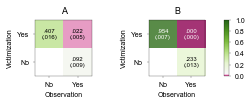

In [10]:
# Plot a heatmap of cumulative probability
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.4, 1.3))
img1 = plot_heatmap_small(ax1, get_basic_motif_stats('data/RO_RE.csv', 'cum prop'), 'A')
img2 = plot_heatmap_small(ax2, get_basic_motif_stats('data/SO_SE.csv', 'cum prop'), 'B')
plt.subplots_adjust(left=0.05, bottom=0.25, top=0.85, wspace=0.2)
cax = plt.axes([0.9, 0.25, 0.02, 0.6])
cbar = fig.colorbar(img1, cax=cax)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/paper/fig_3.pdf', format='pdf')

 ## 3 MOTIF COUNTS IN EMPIRICAL NETWORK

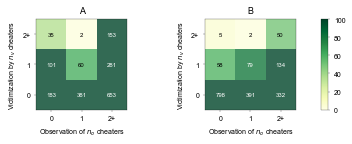

In [10]:
def get_motif_counts(fname, max_obs=None, max_exp=None):
    df = pd.read_csv(fname)
    df = df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
    res = df.groupby([df.total_exp, pd.cut(df.total_obs, 
                                           [-np.inf] + list(range(max_obs)) + [np.inf], 
                                           labels = list(range(max_obs+1)))])["E"].sum().reset_index()
    df = res.groupby([res.total_obs, pd.cut(res.total_exp,[-np.inf] + list(range(max_exp)) + [np.inf], 
                                            labels = list(range(max_exp+1)))])["E"].sum().reset_index()
    freq_piv = pd.pivot_table(df, values="E", index=["total_exp"], columns=["total_obs"])
    freq_piv = freq_piv.replace(0, np.nan)
    
    return freq_piv


def plot_counts(df, ax, title, xticks, yticks, cbar=False):
    img1 = ax.imshow(df, cmap='YlGn', alpha=0.8, vmin=0, vmax=100)
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_xticklabels(xticks)
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_yticklabels(yticks)
    ax.set_xlabel(r'Observation of $n_o$ cheaters')
    ax.set_ylabel(r'Victimization by $n_v$ cheaters')
    ax.title.set_text(title)
    
    textcolors = ["k", "w"]
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if np.isnan(df[x][y]) == False:
                text = ax.text(x, y, int(df[x][y]), ha="center", va="center", fontsize=6,
                                color=textcolors[1 if df[x][y] >= 65 else 0])
    
    if cbar:
        cbar = colorbar(img1)
        cbar.solids.set_edgecolor("face")
    
    return img1


xticks = [0, 1, '2+']
yticks = [0, 1, '2+']

# Plot a heatmap of frequencies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 1.9))

counts_simple = get_motif_counts('data/RO_RE.csv', max_obs=2, max_exp=2)
img1 = plot_counts(counts_simple, ax1, 'A', xticks, yticks)

counts_strict = get_motif_counts('data/SO_SE.csv', max_obs=2, max_exp=2)
img2 = plot_counts(counts_strict, ax2, 'B', xticks, yticks)

plt.subplots_adjust(left=0.04, bottom=0.22, top=0.88, wspace=0.2)
cax = plt.axes([0.9, 0.22, 0.02, 0.66])
cbar = fig.colorbar(img1, cax=cax)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/paper/fig_s5.pdf', format='pdf')

## 4 CHI SQUARE TESTS

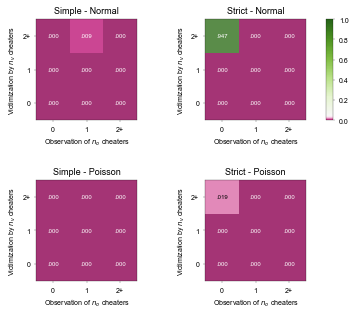

In [311]:
xticks = [0, 1, '2+']
yticks = [0, 1, '2+']

def get_chi_sq(fname, stat):
    simple_data = pd.read_csv(fname)
    piv = pd.pivot_table(simple_data, values=stat, index=["total_exp"], columns=["total_obs"])
    return piv

fig, ax = plt.subplots(2, 2, figsize=(5, 5.5))

piv1 = get_chi_sq('data/chi_sq/RO_RE_chi_sq_norm.csv', stat='norm_pval') 
img1 = plot_heatmap(ax[0,0], piv1, xticks, yticks, 'Simple - Normal')

piv2 = get_chi_sq('data/chi_sq/SO_SE_chi_sq_norm.csv', stat='norm_pval')
plot_heatmap(ax[0,1], piv2, xticks, yticks, 'Strict - Normal')

piv3 = get_chi_sq('data/chi_sq/RO_RE_chi_sq_poiss.csv', stat='pois_pval') 
plot_heatmap(ax[1,0], piv3, xticks, yticks, 'Simple - Poisson')

piv4 = get_chi_sq('data/chi_sq/SO_SE_chi_sq_poiss.csv', stat='pois_pval')
plot_heatmap(ax[1,1], piv4, xticks, yticks, 'Strict - Poisson')

plt.subplots_adjust(left=0.04, bottom=0.22, top=0.88, wspace=0.2, hspace=0.6)
cax = plt.axes([0.9, 0.625, 0.02, 0.255])
cbar = fig.colorbar(img1, cax=cax)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/paper/fig_s7.pdf', format='pdf')

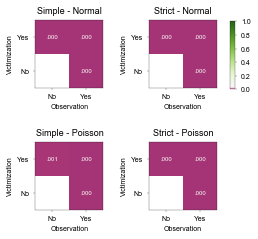

In [312]:
def enter_data(m01, m10, m11):
    df = pd.DataFrame({"O": [0, 0, 1, 1], 
                       "V": [0, 1, 0, 1], 
                       "p_val": [np.NaN, m10, m01, m11]})
    piv = pd.pivot_table(df, values="p_val",index=["V"], columns=["O"])
    return piv

fig, ax = plt.subplots(2, 2, figsize=(3.4, 4.4))
img1 = plot_heatmap_small(ax[0,0], enter_data(0.0, 0.0, 0.0), 'Simple - Normal')
plot_heatmap_small(ax[0,1], enter_data(0.0, 0.0, 0.0), 'Strict - Normal')
plot_heatmap_small(ax[1,0], enter_data(0.0, 0.001, 0.0), 'Simple - Poisson')
plot_heatmap_small(ax[1,1], enter_data(0.0, 0.0, 0.0), 'Strict - Poisson')


plt.subplots_adjust(left=0.05, bottom=0.25, top=0.85, wspace=0.2, hspace=0.8)
cax = plt.axes([0.9, 0.63, 0.02, 0.215])
cbar = fig.colorbar(img1, cax=cax)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/paper/fig_s6.pdf', format='pdf')